In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import TimestampedGeoJson

In [2]:
df = pd.read_csv('../data_processed/data_ml_results.csv')

In [3]:
df['logradouro'].unique()

<StringArray>
['SP 330', 'SP 348', 'SP 150', 'SP 270', 'SP 310', 'SP 070', 'SP 280',
 'SP 123']
Length: 8, dtype: str

In [4]:
mask = df['logradouro'] == 'SP 270'

df_sp270 = df[mask]

In [5]:
df_sp270['hora'].value_counts()

hora
7     411
18    379
6     319
17    315
19    300
16    291
8     279
14    219
20    206
9     205
15    202
13    188
12    183
22    181
11    177
21    170
5     160
10    142
0     124
23    119
4      83
1      81
2      67
3      53
Name: count, dtype: int64

In [6]:
df_sp270['dia_semana'].value_counts()

dia_semana
4    781
5    726
3    682
2    678
6    674
0    664
1    649
Name: count, dtype: int64

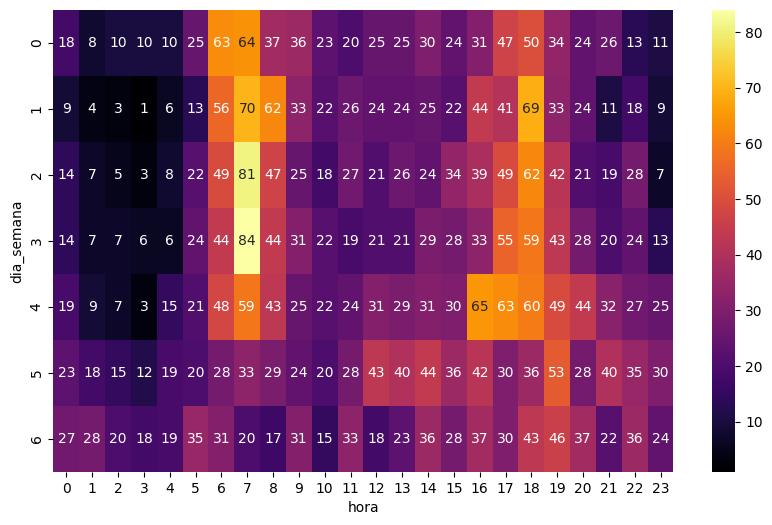

In [7]:
density = df_sp270.pivot_table(
    index='dia_semana',
    columns='hora',
    values='score',
    aggfunc='count' 
)

plt.figure(figsize=(10, 6))
sns.heatmap(density, cmap='inferno', annot=True)
plt.show()

In [8]:
df_sp270['lat_grid'] = round(df_sp270['latitude'], 2)
df_sp270['lon_grid'] = round(df_sp270['longitude'], 2)

<Axes: xlabel='lon_grid', ylabel='lat_grid'>

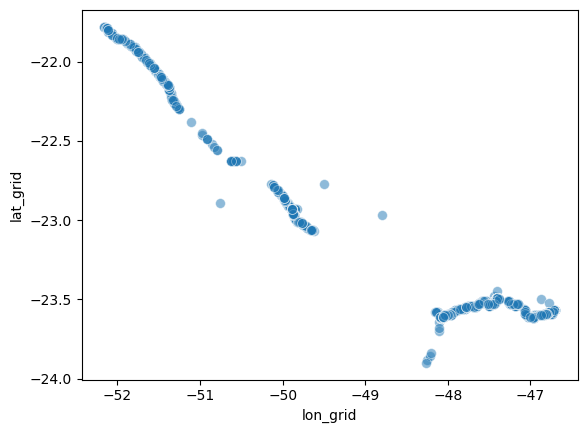

In [9]:
sns.scatterplot(
    data=df_sp270,
    x='lon_grid',
    y='lat_grid',
    alpha=0.5,
    s=50
)

In [10]:
df_grid = df_sp270.groupby(by=['lat_grid', 'lon_grid', 'hora', 'dia_semana'])['score'].sum().reset_index()

In [11]:
df_grid.sort_values(by='score', ascending=False, inplace=True)

In [12]:
df_grid.head(10)

,lat_grid,lon_grid,hora,dia_semana,score
1953,-23.58,-46.78,18,4,223.234249
1613,-23.59,-46.76,3,6,149.770148
1380,-23.59,-46.82,4,6,149.539749
1494,-23.59,-46.80,5,6,149.148052
856,-23.60,-46.89,6,0,148.974942
1021,-23.60,-46.86,4,6,146.130855
1989,-23.58,-46.77,6,6,144.601697
1153,-23.60,-46.84,7,2,144.293019
970,-23.60,-46.87,7,6,144.278610
1979,-23.58,-46.77,4,2,137.601348


In [74]:
total_score = []

for i in range(7):

    day = []

    for j in range (24):

        mask = (df_grid['dia_semana'] == i) & (df_grid['hora'] == j)

        day.append(df_grid.loc[mask, 'score'].sum())

    total_score.append(day)

In [75]:
df_grid['normalized_score'] = df_grid.apply(lambda row: row['score'] / total_score[int(row['dia_semana'])][int(row['hora'])], axis=1)

In [38]:
def sp270_map(day_of_week, hour):

    mask = (df_grid['dia_semana'] == day_of_week) & (df_grid['hora'] == hour)

    df_temp = df_grid[mask]

    sp_map = folium.Map(location=[-23.55, -46.63], zoom_start=10)

    for i, row in df_temp.iterrows():

        folium.CircleMarker(
            location=[row['lat_grid'], row['lon_grid']],
            radius=5 + row['normalized_score']*100,
            color='blue',
            fill=True,
            fill_opacity=0.6,
            tooltip=f"{row['normalized_score']*100:.1f}%"
        ).add_to(sp_map)

    sp_map.save("sp270_scoremap.html")

In [81]:
sp270_map(1, 3) 

In [ ]:
features = []

for i, row in df_grid.iterrows():

    if row['hora'] < 10:
        dtime = f"2024-01-0{int(row['dia_semana'] + 1)} 0{int(row['hora'])}:00:00"
    else:
        dtime = f"2024-01-0{int(row['dia_semana'] + 1)} {int(row['hora'])}:00:00" 

    if row['normalized_score'] < 0.20:
        color = '#00FF00'
    elif row['normalized_score'] < 0.50:
        color = '#FFA500'
    else:
        color = '#FF0000'

    radius = 5 + (row['normalized_score'] * 100)
    if radius > 35:
        radius = 35

    p = {}

    p['type'] = 'Feature'

    p['geometry'] = {
        'type' : 'Point', 
        'coordinates' : [row['lon_grid'], row['lat_grid']]
        }
    
    p['properties'] = {
        'time' : dtime,
        'popup' : f"{row['normalized_score']*100:.2f}%",
        'icon' : 'circle',
        'iconstyle' : {
            'fillColor' : color,
            'color' : color,
            'fillOpacity' : 0.7,
            'radius' : radius
        }
    }

    features.append(p)

In [84]:
animated_map = folium.Map(location=[-23.55, -46.63], zoom_start=10)

TimestampedGeoJson(
    {
        'type' : 'FeatureCollection',
        'features' : features
    },
    period='PT1H',
    duration='PT50M',
    transition_time=100,
    add_last_point=False,
    auto_play=False,
    loop=True
).add_to(animated_map)

animated_map.save("animated_map.html")